# Train LSTM network using Keypoint Features

## Import libraries

In [1]:
# Basic functions
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils
import vidutils

## Create Training and Test Sets

### Load training data
Choose between using synthetic data, real data or both. 

Usage example: If only real data is to be used, set `real_data` to `True` and `syn_data` to `False`.

In [2]:
### --------------------------------------------
# Choose datasets to use
real_data = True
syn_data = False
### --------------------------------------------

X_paths = [] # paths of segment folders
y = [] # designated label

if real_data:
    # Specify directories
    frame_folder = "./data/frames"
    
    # Construct X = folder names, y = the label
    vf_list = []
    for f in os.listdir(frame_folder):
        if not f.startswith('.'):
            vf_list.append(f)
    
    for vf_folder in vf_list:
        # Create path to video
        vf_path = os.path.join(frame_folder, vf_folder)
        print("Current Video: "+ vf_folder)

        # Get individual segment folder
        segfolder_list = os.listdir(vf_path)

        # Check every segment folder
        for seg_folder in segfolder_list:

            if not seg_folder.startswith('.'):
                x_path = os.path.join(vf_path, seg_folder)
                X_paths.append(x_path + '/features.npz')

                # Extract class label from folder name
                label = int(seg_folder.split("_")[2])
                y.append(label)
        
if syn_data:
    # define synthetic data directory
    output_dir = './synthetic_data/output'
    output_list = os.listdir(output_dir)

    for output_folder in output_list:
        if output_folder.startswith('vid'):
            x_path = output_dir + '/' + output_folder
            X_paths.append(x_path)

            # Extract class label from folder name
            params = re.findall(r'\d+', output_folder)
            label = int( (int(params[3]) - 1) / 100)
            y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


In [3]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 54, 2: 49, 4: 50, 5: 51, 8: 52, 9: 52, 0: 48, 3: 50, 6: 48, 7: 50})

In [4]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


### Conversion to Pytorch Dataset
Set seeds for reproducibility and produce pytorch tensor for training.

In [5]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

Definition of dataset class and normalization function

In [6]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features (different based on synthetic or real)
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

# Define normalization function
class norm_with_saved(object):
    """
    Rescale each feature by subtracting mean and dividing by SD over all subjects
    IMPORTANT: Calculate saved_mean and saved_std first.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [7]:
# Define Transformer 
transformer = transforms.Compose([
    transforms.ToTensor() 
])

In [8]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [9]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

### Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [10]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [11]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [12]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


## Model Definition 
Define LSTM architecture and optimizer settings.

In [13]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        return output     

Choose between regression or classification model and select type of loss.

Modify `loss_fn` and `weight_path` to choose the most appropriate loss function and save the results in a directory of your choice.

In [14]:
### --------------------------------------------
# Choose whether to use classification model or regression model
classif_model = True
reg_model = False
### --------------------------------------------
assert (classif_model != reg_model), print("ERROR: Choose one model only")

# Define Loss Function
if classif_model:
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    weight_path = "./models/weights_kpf_classifier.pt"
    num_class = 10

if reg_model:
    # choose between L1 and MSE
    #loss_fn = nn.L1Loss(reduction="sum")
    loss_fn = nn.MSELoss(reduction="sum")
    weight_path = "./models/weights_kpf_regressor.pt"
    num_class = 1


# RNN Model Parameters
model_params = {
    "num_classes": num_class,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 500, # Best classifier: 500
}
model = SyncRNN(model_params)

In [15]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,1,10] for classification and [1,1,1] for regression

torch.Size([1, 1, 10])


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    cuda_available = True
else:
    device = torch.device("cpu")
    cuda_available = False

# Print Model Params
model = model.to(device)
model

SyncRNN(
  (rnn): LSTM(168, 500)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)

Define optimizer settings

In [17]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 3e-3) 

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

In [18]:
# Define Training Parameters
train_params = {
    "num_epochs": 200, 
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": weight_path,
    "cuda_available": cuda_available
}

## Model Training  

Train network and display train/test accuracies.

In [19]:
# train model
if classif_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_class(model, train_params)
if reg_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_reg(model, train_params)

Epoch 0/199, current_lr=0.003



Saved best model weights
Train Loss: 2.395485, Dev Loss: 2.359887, Accuracy: 9.80
----------
Epoch 1/199, current_lr=0.003



Saved best model weights
Train Loss: 2.353545, Dev Loss: 2.351801, Accuracy: 13.73
----------
Epoch 2/199, current_lr=0.003



Saved best model weights
Train Loss: 2.360372, Dev Loss: 2.309215, Accuracy: 9.80
----------
Epoch 3/199, current_lr=0.003



Train Loss: 2.338949, Dev Loss: 2.329699, Accuracy: 9.80
----------
Epoch 4/199, current_lr=0.003



Train Loss: 2.338389, Dev Loss: 2.330211, Accuracy: 19.61
----------
Epoch 5/199, current_lr=0.003



Train Loss: 2.349306, Dev Loss: 2.343828, Accuracy: 7.84
----------
Epoch 6/199, current_lr=0.003



Train Loss: 2.346132, Dev Loss: 2.353916, Accuracy: 9.80
----------
Epoch 7/199, current_lr=0.003



Train Loss: 2.340592, Dev Loss: 2.341767, Accuracy: 9.80
----------
Epoch 8/199, current_lr=0.003



Epoch     9: reducing learning rate of group 0 to 2.1000e-03.
Loading best model weights
Train Loss: 2.349718, Dev Loss: 2.310940, Accuracy: 11.76
----------
Epoch 9/199, current_lr=0.0021



Saved best model weights
Train Loss: 2.338030, Dev Loss: 2.288464, Accuracy: 11.76
----------
Epoch 10/199, current_lr=0.0021



Train Loss: 2.328076, Dev Loss: 2.293288, Accuracy: 9.80
----------
Epoch 11/199, current_lr=0.0021



Train Loss: 2.326004, Dev Loss: 2.314459, Accuracy: 9.80
----------
Epoch 12/199, current_lr=0.0021



Train Loss: 2.332170, Dev Loss: 2.301533, Accuracy: 19.61
----------
Epoch 13/199, current_lr=0.0021



Train Loss: 2.333477, Dev Loss: 2.326797, Accuracy: 9.80
----------
Epoch 14/199, current_lr=0.0021



Train Loss: 2.357298, Dev Loss: 2.327806, Accuracy: 9.80
----------
Epoch 15/199, current_lr=0.0021



Epoch    16: reducing learning rate of group 0 to 1.4700e-03.
Loading best model weights
Train Loss: 2.342816, Dev Loss: 2.318279, Accuracy: 7.84
----------
Epoch 16/199, current_lr=0.0014699999999999997



Train Loss: 2.315596, Dev Loss: 2.290561, Accuracy: 5.88
----------
Epoch 17/199, current_lr=0.0014699999999999997



Saved best model weights
Train Loss: 2.318378, Dev Loss: 2.284408, Accuracy: 17.65
----------
Epoch 18/199, current_lr=0.0014699999999999997



Saved best model weights
Train Loss: 2.319358, Dev Loss: 2.282971, Accuracy: 15.69
----------
Epoch 19/199, current_lr=0.0014699999999999997



Train Loss: 2.319268, Dev Loss: 2.291012, Accuracy: 11.76
----------
Epoch 20/199, current_lr=0.0014699999999999997



Train Loss: 2.326269, Dev Loss: 2.297727, Accuracy: 13.73
----------
Epoch 21/199, current_lr=0.0014699999999999997



Saved best model weights
Train Loss: 2.323166, Dev Loss: 2.281545, Accuracy: 15.69
----------
Epoch 22/199, current_lr=0.0014699999999999997



Train Loss: 2.314797, Dev Loss: 2.289509, Accuracy: 9.80
----------
Epoch 23/199, current_lr=0.0014699999999999997



Train Loss: 2.325304, Dev Loss: 2.285327, Accuracy: 15.69
----------
Epoch 24/199, current_lr=0.0014699999999999997



Saved best model weights
Train Loss: 2.310382, Dev Loss: 2.277110, Accuracy: 15.69
----------
Epoch 25/199, current_lr=0.0014699999999999997



Train Loss: 2.321651, Dev Loss: 2.282896, Accuracy: 13.73
----------
Epoch 26/199, current_lr=0.0014699999999999997



Train Loss: 2.319031, Dev Loss: 2.280142, Accuracy: 13.73
----------
Epoch 27/199, current_lr=0.0014699999999999997



Train Loss: 2.313933, Dev Loss: 2.277886, Accuracy: 15.69
----------
Epoch 28/199, current_lr=0.0014699999999999997



Train Loss: 2.324961, Dev Loss: 2.283061, Accuracy: 9.80
----------
Epoch 29/199, current_lr=0.0014699999999999997



Train Loss: 2.316584, Dev Loss: 2.288415, Accuracy: 9.80
----------
Epoch 30/199, current_lr=0.0014699999999999997



Saved best model weights
Train Loss: 2.313107, Dev Loss: 2.275471, Accuracy: 13.73
----------
Epoch 31/199, current_lr=0.0014699999999999997



Train Loss: 2.316015, Dev Loss: 2.283097, Accuracy: 9.80
----------
Epoch 32/199, current_lr=0.0014699999999999997



Train Loss: 2.308675, Dev Loss: 2.286944, Accuracy: 11.76
----------
Epoch 33/199, current_lr=0.0014699999999999997



Train Loss: 2.323334, Dev Loss: 2.287842, Accuracy: 9.80
----------
Epoch 34/199, current_lr=0.0014699999999999997



Train Loss: 2.320172, Dev Loss: 2.290144, Accuracy: 13.73
----------
Epoch 35/199, current_lr=0.0014699999999999997



Saved best model weights
Train Loss: 2.321436, Dev Loss: 2.274982, Accuracy: 17.65
----------
Epoch 36/199, current_lr=0.0014699999999999997



Train Loss: 2.324550, Dev Loss: 2.294026, Accuracy: 7.84
----------
Epoch 37/199, current_lr=0.0014699999999999997



Train Loss: 2.317770, Dev Loss: 2.283108, Accuracy: 13.73
----------
Epoch 38/199, current_lr=0.0014699999999999997



Train Loss: 2.315211, Dev Loss: 2.279762, Accuracy: 9.80
----------
Epoch 39/199, current_lr=0.0014699999999999997



Train Loss: 2.329134, Dev Loss: 2.286846, Accuracy: 13.73
----------
Epoch 40/199, current_lr=0.0014699999999999997



Train Loss: 2.321036, Dev Loss: 2.278482, Accuracy: 13.73
----------
Epoch 41/199, current_lr=0.0014699999999999997



Epoch    42: reducing learning rate of group 0 to 1.0290e-03.
Loading best model weights
Train Loss: 2.317785, Dev Loss: 2.282470, Accuracy: 15.69
----------
Epoch 42/199, current_lr=0.0010289999999999997



Train Loss: 2.302238, Dev Loss: 2.281008, Accuracy: 5.88
----------
Epoch 43/199, current_lr=0.0010289999999999997



Train Loss: 2.310915, Dev Loss: 2.279421, Accuracy: 15.69
----------
Epoch 44/199, current_lr=0.0010289999999999997



Train Loss: 2.305677, Dev Loss: 2.282389, Accuracy: 7.84
----------
Epoch 45/199, current_lr=0.0010289999999999997



Train Loss: 2.308357, Dev Loss: 2.278114, Accuracy: 11.76
----------
Epoch 46/199, current_lr=0.0010289999999999997



Saved best model weights
Train Loss: 2.309283, Dev Loss: 2.271937, Accuracy: 13.73
----------
Epoch 47/199, current_lr=0.0010289999999999997



Train Loss: 2.304623, Dev Loss: 2.281058, Accuracy: 15.69
----------
Epoch 48/199, current_lr=0.0010289999999999997



Train Loss: 2.304698, Dev Loss: 2.279965, Accuracy: 7.84
----------
Epoch 49/199, current_lr=0.0010289999999999997



Train Loss: 2.303591, Dev Loss: 2.273007, Accuracy: 13.73
----------
Epoch 50/199, current_lr=0.0010289999999999997



Train Loss: 2.298614, Dev Loss: 2.272217, Accuracy: 11.76
----------
Epoch 51/199, current_lr=0.0010289999999999997



Saved best model weights
Train Loss: 2.307555, Dev Loss: 2.262284, Accuracy: 13.73
----------
Epoch 52/199, current_lr=0.0010289999999999997



Train Loss: 2.313985, Dev Loss: 2.279546, Accuracy: 5.88
----------
Epoch 53/199, current_lr=0.0010289999999999997



Train Loss: 2.311583, Dev Loss: 2.284680, Accuracy: 9.80
----------
Epoch 54/199, current_lr=0.0010289999999999997



Train Loss: 2.303152, Dev Loss: 2.277140, Accuracy: 5.88
----------
Epoch 55/199, current_lr=0.0010289999999999997



Train Loss: 2.308848, Dev Loss: 2.274910, Accuracy: 11.76
----------
Epoch 56/199, current_lr=0.0010289999999999997



Train Loss: 2.299225, Dev Loss: 2.277257, Accuracy: 11.76
----------
Epoch 57/199, current_lr=0.0010289999999999997



Epoch    58: reducing learning rate of group 0 to 7.2030e-04.
Loading best model weights
Train Loss: 2.298226, Dev Loss: 2.268902, Accuracy: 11.76
----------
Epoch 58/199, current_lr=0.0007202999999999998



Train Loss: 2.302764, Dev Loss: 2.276845, Accuracy: 11.76
----------
Epoch 59/199, current_lr=0.0007202999999999998



Train Loss: 2.295343, Dev Loss: 2.279983, Accuracy: 7.84
----------
Epoch 60/199, current_lr=0.0007202999999999998



Train Loss: 2.300244, Dev Loss: 2.273757, Accuracy: 17.65
----------
Epoch 61/199, current_lr=0.0007202999999999998



Train Loss: 2.300207, Dev Loss: 2.276781, Accuracy: 9.80
----------
Epoch 62/199, current_lr=0.0007202999999999998



Train Loss: 2.299777, Dev Loss: 2.271475, Accuracy: 19.61
----------
Epoch 63/199, current_lr=0.0007202999999999998



Epoch    64: reducing learning rate of group 0 to 5.0421e-04.
Loading best model weights
Train Loss: 2.294372, Dev Loss: 2.273263, Accuracy: 15.69
----------
Epoch 64/199, current_lr=0.0005042099999999998



Train Loss: 2.294090, Dev Loss: 2.276204, Accuracy: 13.73
----------
Epoch 65/199, current_lr=0.0005042099999999998



Train Loss: 2.295188, Dev Loss: 2.268955, Accuracy: 13.73
----------
Epoch 66/199, current_lr=0.0005042099999999998



Train Loss: 2.293823, Dev Loss: 2.274158, Accuracy: 11.76
----------
Epoch 67/199, current_lr=0.0005042099999999998



Train Loss: 2.292617, Dev Loss: 2.273436, Accuracy: 11.76
----------
Epoch 68/199, current_lr=0.0005042099999999998



Train Loss: 2.293370, Dev Loss: 2.275327, Accuracy: 13.73
----------
Epoch 69/199, current_lr=0.0005042099999999998



Epoch    70: reducing learning rate of group 0 to 3.5295e-04.
Loading best model weights
Train Loss: 2.288713, Dev Loss: 2.269210, Accuracy: 13.73
----------
Epoch 70/199, current_lr=0.0003529469999999999



Train Loss: 2.296313, Dev Loss: 2.276185, Accuracy: 11.76
----------
Epoch 71/199, current_lr=0.0003529469999999999



Train Loss: 2.289756, Dev Loss: 2.270461, Accuracy: 13.73
----------
Epoch 72/199, current_lr=0.0003529469999999999



Train Loss: 2.292544, Dev Loss: 2.279979, Accuracy: 9.80
----------
Epoch 73/199, current_lr=0.0003529469999999999



Train Loss: 2.291867, Dev Loss: 2.266522, Accuracy: 15.69
----------
Epoch 74/199, current_lr=0.0003529469999999999



Train Loss: 2.292825, Dev Loss: 2.268404, Accuracy: 15.69
----------
Epoch 75/199, current_lr=0.0003529469999999999



Epoch    76: reducing learning rate of group 0 to 2.4706e-04.
Loading best model weights
Train Loss: 2.289887, Dev Loss: 2.265624, Accuracy: 17.65
----------
Epoch 76/199, current_lr=0.0002470628999999999



Train Loss: 2.288419, Dev Loss: 2.274834, Accuracy: 13.73
----------
Epoch 77/199, current_lr=0.0002470628999999999



Train Loss: 2.288503, Dev Loss: 2.272637, Accuracy: 19.61
----------
Epoch 78/199, current_lr=0.0002470628999999999



Train Loss: 2.291619, Dev Loss: 2.276165, Accuracy: 9.80
----------
Epoch 79/199, current_lr=0.0002470628999999999



Train Loss: 2.292036, Dev Loss: 2.265512, Accuracy: 11.76
----------
Epoch 80/199, current_lr=0.0002470628999999999



Train Loss: 2.291908, Dev Loss: 2.275275, Accuracy: 15.69
----------
Epoch 81/199, current_lr=0.0002470628999999999



Epoch    82: reducing learning rate of group 0 to 1.7294e-04.
Loading best model weights
Train Loss: 2.288214, Dev Loss: 2.273211, Accuracy: 13.73
----------
Epoch 82/199, current_lr=0.00017294402999999992



Train Loss: 2.287119, Dev Loss: 2.277616, Accuracy: 11.76
----------
Epoch 83/199, current_lr=0.00017294402999999992



Train Loss: 2.287433, Dev Loss: 2.275260, Accuracy: 11.76
----------
Epoch 84/199, current_lr=0.00017294402999999992



Train Loss: 2.292092, Dev Loss: 2.282319, Accuracy: 11.76
----------
Epoch 85/199, current_lr=0.00017294402999999992



Train Loss: 2.287144, Dev Loss: 2.276613, Accuracy: 9.80
----------
Epoch 86/199, current_lr=0.00017294402999999992



Train Loss: 2.288237, Dev Loss: 2.270781, Accuracy: 17.65
----------
Epoch 87/199, current_lr=0.00017294402999999992



Epoch    88: reducing learning rate of group 0 to 1.2106e-04.
Loading best model weights
Train Loss: 2.285961, Dev Loss: 2.270640, Accuracy: 21.57
----------
Epoch 88/199, current_lr=0.00012106082099999994



Train Loss: 2.288236, Dev Loss: 2.277389, Accuracy: 13.73
----------
Epoch 89/199, current_lr=0.00012106082099999994



Train Loss: 2.287185, Dev Loss: 2.278509, Accuracy: 15.69
----------
Epoch 90/199, current_lr=0.00012106082099999994



Train Loss: 2.285868, Dev Loss: 2.269109, Accuracy: 15.69
----------
Epoch 91/199, current_lr=0.00012106082099999994



Train Loss: 2.289971, Dev Loss: 2.275795, Accuracy: 9.80
----------
Epoch 92/199, current_lr=0.00012106082099999994



Train Loss: 2.286897, Dev Loss: 2.271081, Accuracy: 13.73
----------
Epoch 93/199, current_lr=0.00012106082099999994



Epoch    94: reducing learning rate of group 0 to 8.4743e-05.
Loading best model weights
Train Loss: 2.287532, Dev Loss: 2.275043, Accuracy: 13.73
----------
Epoch 94/199, current_lr=8.474257469999996e-05



Train Loss: 2.288789, Dev Loss: 2.266454, Accuracy: 17.65
----------
Epoch 95/199, current_lr=8.474257469999996e-05



Train Loss: 2.288193, Dev Loss: 2.268393, Accuracy: 15.69
----------
Epoch 96/199, current_lr=8.474257469999996e-05



Train Loss: 2.286615, Dev Loss: 2.273270, Accuracy: 15.69
----------
Epoch 97/199, current_lr=8.474257469999996e-05



Saved best model weights
Train Loss: 2.286621, Dev Loss: 2.259633, Accuracy: 17.65
----------
Epoch 98/199, current_lr=8.474257469999996e-05



Train Loss: 2.288950, Dev Loss: 2.276168, Accuracy: 11.76
----------
Epoch 99/199, current_lr=8.474257469999996e-05



Train Loss: 2.286125, Dev Loss: 2.267790, Accuracy: 17.65
----------
Epoch 100/199, current_lr=8.474257469999996e-05



Train Loss: 2.288345, Dev Loss: 2.287101, Accuracy: 7.84
----------
Epoch 101/199, current_lr=8.474257469999996e-05



Train Loss: 2.283859, Dev Loss: 2.265614, Accuracy: 13.73
----------
Epoch 102/199, current_lr=8.474257469999996e-05



Train Loss: 2.288645, Dev Loss: 2.266428, Accuracy: 17.65
----------
Epoch 103/199, current_lr=8.474257469999996e-05



Epoch   104: reducing learning rate of group 0 to 5.9320e-05.
Loading best model weights
Train Loss: 2.288964, Dev Loss: 2.267790, Accuracy: 17.65
----------
Epoch 104/199, current_lr=5.931980228999997e-05



Train Loss: 2.285241, Dev Loss: 2.275048, Accuracy: 15.69
----------
Epoch 105/199, current_lr=5.931980228999997e-05



Train Loss: 2.284589, Dev Loss: 2.263109, Accuracy: 19.61
----------
Epoch 106/199, current_lr=5.931980228999997e-05



Train Loss: 2.282515, Dev Loss: 2.266168, Accuracy: 17.65
----------
Epoch 107/199, current_lr=5.931980228999997e-05



Train Loss: 2.287325, Dev Loss: 2.268672, Accuracy: 11.76
----------
Epoch 108/199, current_lr=5.931980228999997e-05



Train Loss: 2.285533, Dev Loss: 2.275336, Accuracy: 15.69
----------
Epoch 109/199, current_lr=5.931980228999997e-05



Epoch   110: reducing learning rate of group 0 to 4.1524e-05.
Loading best model weights
Train Loss: 2.286207, Dev Loss: 2.271036, Accuracy: 13.73
----------
Epoch 110/199, current_lr=4.1523861602999974e-05



Train Loss: 2.285469, Dev Loss: 2.276601, Accuracy: 9.80
----------
Epoch 111/199, current_lr=4.1523861602999974e-05



Train Loss: 2.286075, Dev Loss: 2.268499, Accuracy: 17.65
----------
Epoch 112/199, current_lr=4.1523861602999974e-05



Train Loss: 2.284819, Dev Loss: 2.263207, Accuracy: 15.69
----------
Epoch 113/199, current_lr=4.1523861602999974e-05



Train Loss: 2.284825, Dev Loss: 2.272203, Accuracy: 15.69
----------
Epoch 114/199, current_lr=4.1523861602999974e-05



Train Loss: 2.284795, Dev Loss: 2.264668, Accuracy: 15.69
----------
Epoch 115/199, current_lr=4.1523861602999974e-05



Epoch   116: reducing learning rate of group 0 to 2.9067e-05.
Loading best model weights
Train Loss: 2.286507, Dev Loss: 2.271964, Accuracy: 9.80
----------
Epoch 116/199, current_lr=2.906670312209998e-05



Train Loss: 2.288131, Dev Loss: 2.278845, Accuracy: 13.73
----------
Epoch 117/199, current_lr=2.906670312209998e-05



Train Loss: 2.286246, Dev Loss: 2.272773, Accuracy: 11.76
----------
Epoch 118/199, current_lr=2.906670312209998e-05



Train Loss: 2.285419, Dev Loss: 2.265605, Accuracy: 15.69
----------
Epoch 119/199, current_lr=2.906670312209998e-05



Train Loss: 2.284667, Dev Loss: 2.270913, Accuracy: 15.69
----------
Epoch 120/199, current_lr=2.906670312209998e-05



Train Loss: 2.286076, Dev Loss: 2.272469, Accuracy: 11.76
----------
Epoch 121/199, current_lr=2.906670312209998e-05



Epoch   122: reducing learning rate of group 0 to 2.0347e-05.
Loading best model weights
Train Loss: 2.286997, Dev Loss: 2.273840, Accuracy: 9.80
----------
Epoch 122/199, current_lr=2.0346692185469984e-05



Train Loss: 2.287172, Dev Loss: 2.272637, Accuracy: 15.69
----------
Epoch 123/199, current_lr=2.0346692185469984e-05



Train Loss: 2.286286, Dev Loss: 2.271763, Accuracy: 15.69
----------
Epoch 124/199, current_lr=2.0346692185469984e-05



Train Loss: 2.287744, Dev Loss: 2.276434, Accuracy: 15.69
----------
Epoch 125/199, current_lr=2.0346692185469984e-05



Train Loss: 2.286808, Dev Loss: 2.270479, Accuracy: 17.65
----------
Epoch 126/199, current_lr=2.0346692185469984e-05



Train Loss: 2.284788, Dev Loss: 2.263856, Accuracy: 23.53
----------
Epoch 127/199, current_lr=2.0346692185469984e-05



Epoch   128: reducing learning rate of group 0 to 1.4243e-05.
Loading best model weights
Train Loss: 2.285677, Dev Loss: 2.271736, Accuracy: 17.65
----------
Epoch 128/199, current_lr=1.4242684529828988e-05



Train Loss: 2.288928, Dev Loss: 2.272304, Accuracy: 15.69
----------
Epoch 129/199, current_lr=1.4242684529828988e-05



Train Loss: 2.284365, Dev Loss: 2.269370, Accuracy: 15.69
----------
Epoch 130/199, current_lr=1.4242684529828988e-05



Train Loss: 2.284355, Dev Loss: 2.268403, Accuracy: 13.73
----------
Epoch 131/199, current_lr=1.4242684529828988e-05



Train Loss: 2.282788, Dev Loss: 2.281645, Accuracy: 7.84
----------
Epoch 132/199, current_lr=1.4242684529828988e-05



Train Loss: 2.283948, Dev Loss: 2.277550, Accuracy: 13.73
----------
Epoch 133/199, current_lr=1.4242684529828988e-05



Epoch   134: reducing learning rate of group 0 to 9.9699e-06.
Loading best model weights
Train Loss: 2.286616, Dev Loss: 2.262231, Accuracy: 11.76
----------
Epoch 134/199, current_lr=9.969879170880291e-06



Train Loss: 2.285083, Dev Loss: 2.267366, Accuracy: 15.69
----------
Epoch 135/199, current_lr=9.969879170880291e-06



Train Loss: 2.289606, Dev Loss: 2.281669, Accuracy: 15.69
----------
Epoch 136/199, current_lr=9.969879170880291e-06



Train Loss: 2.284344, Dev Loss: 2.283270, Accuracy: 9.80
----------
Epoch 137/199, current_lr=9.969879170880291e-06



Train Loss: 2.285207, Dev Loss: 2.277525, Accuracy: 13.73
----------
Epoch 138/199, current_lr=9.969879170880291e-06



Train Loss: 2.283472, Dev Loss: 2.275212, Accuracy: 11.76
----------
Epoch 139/199, current_lr=9.969879170880291e-06



Epoch   140: reducing learning rate of group 0 to 6.9789e-06.
Loading best model weights
Train Loss: 2.286815, Dev Loss: 2.271217, Accuracy: 11.76
----------
Epoch 140/199, current_lr=6.978915419616203e-06



Train Loss: 2.283594, Dev Loss: 2.271634, Accuracy: 17.65
----------
Epoch 141/199, current_lr=6.978915419616203e-06



Train Loss: 2.282643, Dev Loss: 2.278739, Accuracy: 15.69
----------
Epoch 142/199, current_lr=6.978915419616203e-06



Train Loss: 2.284613, Dev Loss: 2.265669, Accuracy: 17.65
----------
Epoch 143/199, current_lr=6.978915419616203e-06



Train Loss: 2.285787, Dev Loss: 2.266286, Accuracy: 17.65
----------
Epoch 144/199, current_lr=6.978915419616203e-06



Train Loss: 2.285331, Dev Loss: 2.272408, Accuracy: 15.69
----------
Epoch 145/199, current_lr=6.978915419616203e-06



Epoch   146: reducing learning rate of group 0 to 4.8852e-06.
Loading best model weights
Train Loss: 2.288146, Dev Loss: 2.265219, Accuracy: 17.65
----------
Epoch 146/199, current_lr=4.885240793731342e-06



Train Loss: 2.285255, Dev Loss: 2.274694, Accuracy: 13.73
----------
Epoch 147/199, current_lr=4.885240793731342e-06



Train Loss: 2.288007, Dev Loss: 2.267855, Accuracy: 15.69
----------
Epoch 148/199, current_lr=4.885240793731342e-06



Train Loss: 2.285413, Dev Loss: 2.277604, Accuracy: 15.69
----------
Epoch 149/199, current_lr=4.885240793731342e-06



Train Loss: 2.285652, Dev Loss: 2.266025, Accuracy: 17.65
----------
Epoch 150/199, current_lr=4.885240793731342e-06



Train Loss: 2.283805, Dev Loss: 2.274094, Accuracy: 9.80
----------
Epoch 151/199, current_lr=4.885240793731342e-06



Epoch   152: reducing learning rate of group 0 to 3.4197e-06.
Loading best model weights
Train Loss: 2.287581, Dev Loss: 2.273813, Accuracy: 9.80
----------
Epoch 152/199, current_lr=3.4196685556119394e-06



Train Loss: 2.285305, Dev Loss: 2.262285, Accuracy: 17.65
----------
Epoch 153/199, current_lr=3.4196685556119394e-06



Train Loss: 2.282762, Dev Loss: 2.272595, Accuracy: 15.69
----------
Epoch 154/199, current_lr=3.4196685556119394e-06



Train Loss: 2.285537, Dev Loss: 2.276403, Accuracy: 13.73
----------
Epoch 155/199, current_lr=3.4196685556119394e-06



Train Loss: 2.287116, Dev Loss: 2.279264, Accuracy: 17.65
----------
Epoch 156/199, current_lr=3.4196685556119394e-06



Train Loss: 2.283007, Dev Loss: 2.275333, Accuracy: 17.65
----------
Epoch 157/199, current_lr=3.4196685556119394e-06



Epoch   158: reducing learning rate of group 0 to 2.3938e-06.
Loading best model weights
Train Loss: 2.284778, Dev Loss: 2.267874, Accuracy: 17.65
----------
Epoch 158/199, current_lr=2.3937679889283576e-06



Train Loss: 2.287120, Dev Loss: 2.264998, Accuracy: 19.61
----------
Epoch 159/199, current_lr=2.3937679889283576e-06



Train Loss: 2.283911, Dev Loss: 2.272312, Accuracy: 15.69
----------
Epoch 160/199, current_lr=2.3937679889283576e-06



Train Loss: 2.283522, Dev Loss: 2.266020, Accuracy: 17.65
----------
Epoch 161/199, current_lr=2.3937679889283576e-06



Train Loss: 2.283687, Dev Loss: 2.260014, Accuracy: 19.61
----------
Epoch 162/199, current_lr=2.3937679889283576e-06



Train Loss: 2.286528, Dev Loss: 2.272400, Accuracy: 17.65
----------
Epoch 163/199, current_lr=2.3937679889283576e-06



Epoch   164: reducing learning rate of group 0 to 1.6756e-06.
Loading best model weights
Train Loss: 2.285364, Dev Loss: 2.267575, Accuracy: 17.65
----------
Epoch 164/199, current_lr=1.6756375922498502e-06



Train Loss: 2.283483, Dev Loss: 2.276734, Accuracy: 15.69
----------
Epoch 165/199, current_lr=1.6756375922498502e-06



Train Loss: 2.286021, Dev Loss: 2.268762, Accuracy: 17.65
----------
Epoch 166/199, current_lr=1.6756375922498502e-06



Train Loss: 2.283451, Dev Loss: 2.269287, Accuracy: 15.69
----------
Epoch 167/199, current_lr=1.6756375922498502e-06



Train Loss: 2.288288, Dev Loss: 2.263375, Accuracy: 19.61
----------
Epoch 168/199, current_lr=1.6756375922498502e-06



Train Loss: 2.284215, Dev Loss: 2.260726, Accuracy: 19.61
----------
Epoch 169/199, current_lr=1.6756375922498502e-06



Epoch   170: reducing learning rate of group 0 to 1.1729e-06.
Loading best model weights
Train Loss: 2.284540, Dev Loss: 2.271071, Accuracy: 17.65
----------
Epoch 170/199, current_lr=1.1729463145748951e-06



Train Loss: 2.284679, Dev Loss: 2.268908, Accuracy: 13.73
----------
Epoch 171/199, current_lr=1.1729463145748951e-06



Train Loss: 2.284699, Dev Loss: 2.276860, Accuracy: 15.69
----------
Epoch 172/199, current_lr=1.1729463145748951e-06



Train Loss: 2.286576, Dev Loss: 2.274749, Accuracy: 17.65
----------
Epoch 173/199, current_lr=1.1729463145748951e-06



Train Loss: 2.286222, Dev Loss: 2.272758, Accuracy: 15.69
----------
Epoch 174/199, current_lr=1.1729463145748951e-06



Train Loss: 2.286758, Dev Loss: 2.272752, Accuracy: 15.69
----------
Epoch 175/199, current_lr=1.1729463145748951e-06



Epoch   176: reducing learning rate of group 0 to 8.2106e-07.
Loading best model weights
Train Loss: 2.283443, Dev Loss: 2.273318, Accuracy: 15.69
----------
Epoch 176/199, current_lr=8.210624202024266e-07



Train Loss: 2.285338, Dev Loss: 2.270808, Accuracy: 15.69
----------
Epoch 177/199, current_lr=8.210624202024266e-07



Train Loss: 2.286782, Dev Loss: 2.272032, Accuracy: 15.69
----------
Epoch 178/199, current_lr=8.210624202024266e-07



Train Loss: 2.283168, Dev Loss: 2.271649, Accuracy: 13.73
----------
Epoch 179/199, current_lr=8.210624202024266e-07



Train Loss: 2.285352, Dev Loss: 2.270008, Accuracy: 19.61
----------
Epoch 180/199, current_lr=8.210624202024266e-07



Train Loss: 2.284891, Dev Loss: 2.265041, Accuracy: 17.65
----------
Epoch 181/199, current_lr=8.210624202024266e-07



Epoch   182: reducing learning rate of group 0 to 5.7474e-07.
Loading best model weights
Train Loss: 2.284255, Dev Loss: 2.264446, Accuracy: 17.65
----------
Epoch 182/199, current_lr=5.747436941416985e-07



Train Loss: 2.284941, Dev Loss: 2.271152, Accuracy: 17.65
----------
Epoch 183/199, current_lr=5.747436941416985e-07



Train Loss: 2.284325, Dev Loss: 2.269740, Accuracy: 19.61
----------
Epoch 184/199, current_lr=5.747436941416985e-07



Train Loss: 2.283931, Dev Loss: 2.276898, Accuracy: 15.69
----------
Epoch 185/199, current_lr=5.747436941416985e-07



Train Loss: 2.284790, Dev Loss: 2.263895, Accuracy: 19.61
----------
Epoch 186/199, current_lr=5.747436941416985e-07



Train Loss: 2.285853, Dev Loss: 2.270072, Accuracy: 19.61
----------
Epoch 187/199, current_lr=5.747436941416985e-07



Epoch   188: reducing learning rate of group 0 to 4.0232e-07.
Loading best model weights
Train Loss: 2.284679, Dev Loss: 2.276082, Accuracy: 17.65
----------
Epoch 188/199, current_lr=4.0232058589918897e-07



Train Loss: 2.283247, Dev Loss: 2.267633, Accuracy: 15.69
----------
Epoch 189/199, current_lr=4.0232058589918897e-07



Train Loss: 2.285632, Dev Loss: 2.274190, Accuracy: 15.69
----------
Epoch 190/199, current_lr=4.0232058589918897e-07



Train Loss: 2.285215, Dev Loss: 2.274184, Accuracy: 15.69
----------
Epoch 191/199, current_lr=4.0232058589918897e-07



Train Loss: 2.283097, Dev Loss: 2.279286, Accuracy: 13.73
----------
Epoch 192/199, current_lr=4.0232058589918897e-07



Train Loss: 2.285247, Dev Loss: 2.271991, Accuracy: 17.65
----------
Epoch 193/199, current_lr=4.0232058589918897e-07



Epoch   194: reducing learning rate of group 0 to 2.8162e-07.
Loading best model weights
Train Loss: 2.283430, Dev Loss: 2.276165, Accuracy: 13.73
----------
Epoch 194/199, current_lr=2.8162441012943226e-07



Train Loss: 2.285877, Dev Loss: 2.265457, Accuracy: 17.65
----------
Epoch 195/199, current_lr=2.8162441012943226e-07



Train Loss: 2.287426, Dev Loss: 2.270170, Accuracy: 17.65
----------
Epoch 196/199, current_lr=2.8162441012943226e-07



Train Loss: 2.285890, Dev Loss: 2.268424, Accuracy: 15.69
----------
Epoch 197/199, current_lr=2.8162441012943226e-07



Train Loss: 2.283395, Dev Loss: 2.273438, Accuracy: 17.65
----------
Epoch 198/199, current_lr=2.8162441012943226e-07



Train Loss: 2.282295, Dev Loss: 2.268998, Accuracy: 17.65
----------
Epoch 199/199, current_lr=2.8162441012943226e-07



Epoch   200: reducing learning rate of group 0 to 1.9714e-07.
Loading best model weights
Train Loss: 2.285828, Dev Loss: 2.276084, Accuracy: 19.61
----------


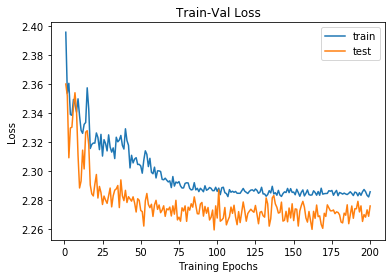

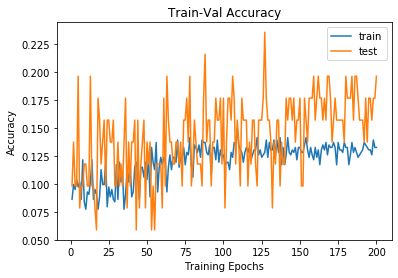

In [20]:
# plot loss and accuracies over epochs
trainutils.plot_loss(loss_hist, metric_hist)